# Тестовое задание 

   Ваша задача написать пайплайн для тренировки модели глубоко обучения (любую – **embeddings + LSTM, Bert** …) с использованием следующих инструментов: pytorch, sklearn, matplotlib – для решения задачи **NER** (извлечения сущностей).

   В качестве данных используется датасет **Conll2003** с четырьмя классами **Per, Org, Loc, Misc** в формате **Conll**.

   В тетрадке ниже заданы основные классы и функции для построения требуемого пайплайн, какие-то уже имплементированы, какие-то – нет. Их требуется доработать. Тем не менее если данный набор абстракций вам не подходит Вы можете написать свой пайплайн «с нуля», однако обоснованность у этих действий должна быть.

**Что оценивается в первую очередь:**
- Выбранная архитектура для решения задачи
- Выбранные предобученные веса 
- Полученные метрики

**Затем:**
- Глубина разведочного анализа
- Какая схема теггирования используется (**BIO, IO** или другие)
- Каким образом производится расчет метрик (потокенный отчет, отчет по точному совпадению спанов сущностей)

**С меньшим приоритетом:** 
- Скорость предобработки и постобработки данных 
- Стиль кода

Задачу NER можно свести к задаче классификации слов, в данном случае на 5 классов. 

  
В качестве основной архитектуры мною был выбран предобученный DistilBert. Он обучается быстрее чем обычный Bert и сильно не проигрывает в качестве. Это позволила мне в условиях ограниченных сроков больше поэкспериментировать с параметрами модели. DistilBert, как и Bert, на мой взгляд, являются хорошим выбором для решения задачи, так как обладают знанием языка и из них можно получить хорошие эмбеддинги  

  
После получения эмбеддингов из DistilBert, я подаю по очереди каждое слово в полносвязный слой и из него получаю метку класса. 



In [1]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

--2021-05-23 13:54:04--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827012 (808K) [text/plain]
Saving to: ‘eng.testa’

eng.testa           100%[===================>] 807.63K  --.-KB/s    in 0.04s   

2021-05-23 13:54:04 (20.3 MB/s) - ‘eng.testa’ saved [827012/827012]

--2021-05-23 13:54:05--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3281528 (3.1M) [text/plain]
S

In [2]:
!head eng.train 

-DOCSTART- -X- O O

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O


In [3]:
from torch.utils.data import Dataset, DataLoader
from typing import List
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
from sklearn.metrics import classification_report

In [4]:
def read_data(file):
  lines = open(file, "r").readlines()
  data = {"sentences": [], "labels_per_sent": []}
  sentence, labels = [], []
  for line in tqdm(lines):
    line = line.strip()
    if not line:
      if sentence and labels:
        assert len(sentence) == len(labels)
        data["sentences"].append(sentence)
        data["labels_per_sent"].append(labels)
        sentence, labels = [], []
      continue
    if line.startswith("-DOCSTART-"):
      continue
    else:
      values = line.split(" ")
      try:
        token, _, _, label = values
        sentence.append(token)
        if label != 'O':
          labels.append(label.split('-')[-1])
        else:
          labels.append(label)

      except Exception as e:
        print(f"Error has occur: {e}")
        continue
  return data


train = read_data("eng.train")
valid = read_data("eng.testa")

100%|██████████| 55045/55045 [00:00<00:00, 682117.01it/s]


In [5]:
train["sentences"][0], train["labels_per_sent"][0]

(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['ORG', 'O', 'MISC', 'O', 'O', 'O', 'MISC', 'O', 'O'])

In [6]:
valid["sentences"][0], valid["labels_per_sent"][0]

(['CRICKET',
  '-',
  'LEICESTERSHIRE',
  'TAKE',
  'OVER',
  'AT',
  'TOP',
  'AFTER',
  'INNINGS',
  'VICTORY',
  '.'],
 ['O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [7]:
def get_label_distribution(labels: List[List[str]]):
  labels = [label for labels_per_sent in labels for label in labels_per_sent]
  return Counter(labels)

In [8]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

In [9]:
train_distribution


Counter({'ORG': 10025, 'O': 169578, 'MISC': 4593, 'PER': 11128, 'LOC': 8297})

Train distribution


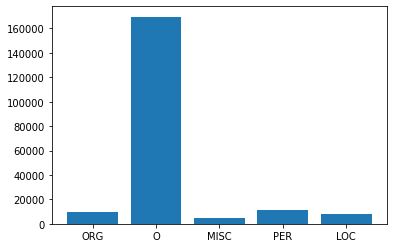

Valid distribution


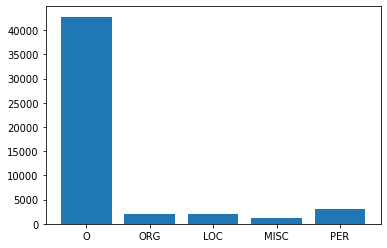

In [10]:
def visualize_distr(data: Counter):
  labels = list(data.keys())
  plt.bar(x=labels, height=list(data.values()))
  plt.show()


print("Train distribution")
visualize_distr(train_distribution)
print("Valid distribution")
visualize_distr(valid_distribution)

In [11]:

!pip install transformers

# Preprocessing data

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [13]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
modelBert = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [14]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, random_split
l = np.array([])
for i in train["labels_per_sent"]:
  l  = np.append(l,np.array(i)) 
le = LabelEncoder()
le.fit(l)

LabelEncoder()

In [15]:

class NERDataset(Dataset):

  def __init__(self, data, tokenizer):
    self.tokenized =[tokenizer(' '.join(i)) for i in data["sentences"]] # Cклеиваю слова для подачи в токенизатор Берта

    self.label =[le.transform(data["labels_per_sent"][i]) for i in range(len(data["labels_per_sent"]))] # кодирую классы
    
  
  def __getitem__(self,index):
 
     
   #  print(self.tokenized[index])
     return {"tokenized": self.tokenized[index] , "label": self.label[index]}
  def __len__(self):
     return len(self.label)
torch.manual_seed(2) 
train_dataset = NERDataset(train,tokenizer )
valid_dataset = NERDataset(valid, tokenizer )
train_dataset = random_split(train_dataset, [len(train_dataset)])[0]
valid_dataset =  random_split(valid_dataset , [len(valid_dataset )])[0]

In [16]:
from torch.utils.data import Sampler


class ReviewsSampler(Sampler):
    def __init__(self, subset, batch_size=32):
        self.batch_size = batch_size
        self.subset = subset

        self.indices = subset.indices
        # tokenized for our data
        self.tokenized = np.array(subset.dataset.tokenized)[self.indices]

    def __iter__(self):

        batch_idx = []
        # index in sorted data
        for index in np.argsort(list(map(len, self.tokenized))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return len(self.dataset)

In [17]:

# Паддинг до самого длинного предложения в батче 
def get_padded(values, labels): 
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in values])
 
    labels =  np.array([[6]+list(label)  + [6]*(max_len-len(label )-1) for label  in labels]) # в качестве падинга использую 6, которую не буду учитывать при обучении модели
   # print(len(labels))
    return padded, labels 

def collate_fn(batch):

    inputs = []
    labels = []
    for elem in batch:
        inputs.append(elem['tokenized'])
        labels.append(elem['label'])

 
    inputs, labels  = get_padded([i['input_ids']for i in inputs], [i for i in labels]) ## padded inputs

    attention_mask = np.where(inputs  != 0, 1, 0)


    return {"inputs": torch.tensor(inputs), "labels": torch.tensor(labels), 'attention_mask' : torch.tensor(attention_mask)}

In [18]:
train_loader = DataLoader(train_dataset, batch_sampler=ReviewsSampler(train_dataset), collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_sampler=ReviewsSampler(valid_dataset), collate_fn=collate_fn)

In [19]:
device = "cuda:0"

In [20]:
for i in train_loader :
  print(i['inputs'][0])
  print(i['labels'][0])
  break

tensor([ 101, 3463, 1997, 2827, 4043, 2223, 3503, 2209, 2012, 1996, 5353, 1012,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0])
tensor([6, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6])


# Fine-Tuning BERT

In [21]:
class NERModel(nn.Module):

  def __init__(self, pretrain_model, dropout = 0.6):
        super().__init__()
        self.bert = pretrain_model
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.cls_layer = nn.Sequential(
                            nn.Linear(769,256),
                            self.dropout,
                            self.relu,
                            #nn.Linear(256,128), # При добавлении полносвязного слоя качетсво падало, так как переобучение наступало быстрее
                            #self.dropout,
                            #self.relu,
                            #nn.Linear(128,5)
                            nn.Linear(256,5)
                            
                            
                        )

  def forward(self, inputs, attention_mask):
    x = self.bert(inputs,attention_mask =attention_mask)[0]
    clsif =[] #Вектор содержащий предсказния модели для каждого слова
    
    for i in range(x.shape[1]):
        
        h = torch.tensor([i]*x.shape[0]*x.shape[1]).reshape(x.shape[0],x.shape[1],-1).to(device) # тут я добовляю к выходу из Берта признак,
                                                                                                 #содержащий номер слова для которого идет предсказание

        if i==0:
          clsif = self.cls_layer(torch.cat((x, h), dim=2)[:,i])
           
          dim = clsif.shape[1]
        else:
          clsif  = torch.cat((clsif , self.cls_layer(torch.cat((x, h), dim=2)[:,i])), dim=1)
   

    return clsif.reshape(-1,dim)

    

In [68]:
modelBert = model_class.from_pretrained(pretrained_weights).to(device)
model = NERModel(modelBert)
model = model.to(device)

In [69]:
def transform(predictions: List[torch.tensor]):

  predictions = predictions.view(-1,5)
  return torch.argmax(predictions, dim=1)



In [70]:
def count_metrics(gold_labels_per_sentence, predict_labels_per_sentence):
    
   predict_labels_per_sentence = predict_labels_per_sentence[gold_labels_per_sentence!=6] # Ведем подсечт метрик без учета паддинга 
   gold_labels_per_sentence = gold_labels_per_sentence[gold_labels_per_sentence!=6]
   
   print(classification_report(gold_labels_per_sentence, predict_labels_per_sentence ))

In [71]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=6e-6)


              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85      2094
         1.0       0.78      0.78      0.78      1268
         2.0       0.97      0.97      0.97     42759
         3.0       0.85      0.80      0.83      2092
         4.0       0.86      0.86      0.86      3149

    accuracy                           0.95     51362
   macro avg       0.86      0.86      0.86     51362
weighted avg       0.95      0.95      0.95     51362



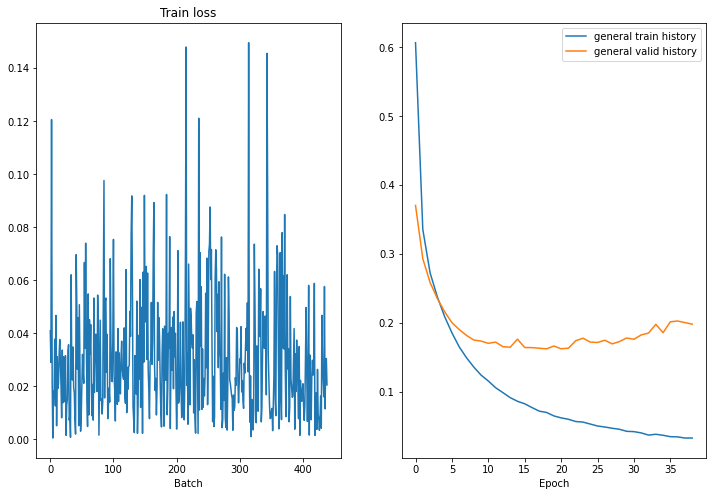

End eposh #39


In [72]:
from IPython.display import clear_output
losses = {"train_losses": [], "valid_losses": []}

epochs = 40
clip = 1
train_history=[]
valid_history  = []
best_valid_loss = float('inf')
for epoch in range(epochs):
  print(f"Start eposh #{epoch}")
  epoch_loss =0 
  history = []
  i=0
  model.train()
  train_loss =0
  bath_size =0
  for train_batch in train_loader:
    # При обучении CrossEntropyLoss с весами не был получен прирост в метриках, 0 и 1 класс часто путались с другими 
    teg_0,teg_1,teg_2,teg_3,teg_4 = 0, 0, 0, 0, 0
    teg_0 +=sum(sum(train_batch['labels']==0))
    teg_1 +=sum(sum(train_batch['labels']==1))
    teg_2 +=sum(sum(train_batch['labels']==2))
    teg_3 +=sum(sum(train_batch['labels']==3))
    teg_4 +=sum(sum(train_batch['labels']==4))
    sum_teg = teg_0 + teg_4 + teg_3 + teg_2 + teg_1
    #weights = torch.tensor([sum_teg/(teg_0),sum_teg/(teg_1),sum_teg/(teg_2),sum_teg/(teg_3),sum_teg/(teg_4)]).to(device) 
     
    labels = train_batch['labels'].to(device)
    input = train_batch['inputs'].to(device)
    attention_mask = train_batch['attention_mask'].to(device)
 
    output= model(inputs = input,attention_mask =attention_mask )

    optimizer.zero_grad()
      
    labels = labels.view(-1)
    target = np.array([])


    #criterion = nn.CrossEntropyLoss(weight = weights,ignore_index=6)
    criterion = nn.CrossEntropyLoss(ignore_index=6)
    loss = criterion(output.squeeze(1), labels) 
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    bath_size+=1
    train_loss += loss.item()
        
    history.append(loss.cpu().data.numpy())
    i+=1
    if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if len(train_history)>0 :
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if len(valid_history)>0:
                ax[1].plot(valid_history, label='general valid history')
                #count_metrics(gold_labels, predict_labels)
                count_metrics(gold_labels_all, predict_labels_all)
                plt.legend()
            
            plt.show()
  
  train_history.append(train_loss/bath_size)

  model.eval()
  bath_size =0 
  val_loss=0 
  predict_labels_all, gold_labels_all = np.array([]), np.array([])

  for valid_batch in valid_loader:
    labels = valid_batch['labels'].to(device)
    input = valid_batch['inputs'].to(device)
    attention_mask = valid_batch['attention_mask'].to(device)
    output= model(inputs = input,attention_mask =attention_mask )
    labels = labels.view(-1)
    target = np.array([])

    loss = criterion(output.squeeze(1), labels) 
    bath_size+=1
    val_loss += loss.item()

   
    predict_labels = transform(output)
    gold_labels = labels
    predict_labels_all = np.append(predict_labels_all,predict_labels.cpu())
    gold_labels_all = np.append(gold_labels_all,gold_labels.cpu())

  if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'best-val-model.pt')
  valid_history.append(val_loss/bath_size)




  
  
  print(f"End eposh #{epoch}")



In [73]:
def inv_transform(labels):
    return le.inverse_transform(labels)

In [74]:
def prepos(text, model):
    text = [sent.replace('.', '').split() for sent in text[0]]
    data = {'sentences': text, "labels_per_sent": [['O']*len(i) for i in text]}
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    data_dataset = NERDataset(data,tokenizer )
    data_dataset = random_split(data_dataset, [len(data_dataset)])[0]
    data_loader = DataLoader(data_dataset, batch_sampler=ReviewsSampler(data_dataset), collate_fn=collate_fn)
    model.eval()
    predict_labels_all = np.array([])
    for batch in data_loader:
        
        input = batch['inputs'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        output= model(inputs = input,attention_mask =attention_mask )
        predict_labels = transform(output)    
        
        predict_labels_all = np.append(predict_labels_all,predict_labels[1:].cpu())
        
    
    return inv_transform(list([int(i) for i in predict_labels_all]))

In [75]:
prepos([['London is the capital of Britain']], model)

array(['LOC', 'O', 'O', 'O', 'O', 'LOC', 'MISC'], dtype='<U32')